In [1]:
# prompt: import drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ─────────────────────────────────────────
# test_multiple_classifiers_fast.py
# ─────────────────────────────────────────
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd, numpy as np, json, os, time
import wandb


def fast_search_clf(X_tr, y_tr, X_val, y_val,
                    X_te, y_te, project_dir, fold, *,
                    seed=42, use_wandb=True, wb_group="clf_search"):

    import os, json, time
    import numpy as np
    import pandas as pd
    import wandb
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV, RandomizedSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
    import joblib

    # ─── W&B run ─────────────────────────────────────────────
    if use_wandb:
        wandb_run = wandb.init(
            project="VAE_ADCN",
            group=wb_group,
            job_type=f"fold_{fold}",
            config={"fold": fold, "seed": seed},
            reinit=True
        )
    else:
        wandb_run = None
    # ─────────────────────────────────────────────────────────

    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

    SEARCHERS = {
        "LogReg": HalvingGridSearchCV(
            Pipeline([
                ("scaler", StandardScaler()),
                ("clf", LogisticRegression(solver="saga", max_iter=4000, random_state=seed))
            ]),
            param_grid={
                "clf__penalty": ["l1", "l2"],
                "clf__C": np.logspace(-3, 3, 5)
            },
            scoring="roc_auc", cv=inner_cv,
            factor=2, n_jobs=-1, verbose=0, random_state=seed
        ),

        "SVM": HalvingGridSearchCV(
            Pipeline([
                ("scaler", StandardScaler()),
                ("clf", SVC(probability=True, random_state=seed))
            ]),
            param_grid={
                "clf__kernel": ["rbf"],
                "clf__C": np.logspace(-2, 2, 4),
                "clf__gamma": np.logspace(-4, 0, 5)
            },
            scoring="roc_auc", cv=inner_cv,
            factor=2, n_jobs=-1, verbose=0, random_state=seed
        ),

        "RF": RandomizedSearchCV(
            RandomForestClassifier(n_jobs=-1, random_state=seed, class_weight="balanced"),
            param_distributions={
                "n_estimators": [100, 200, 400, 800],
                "max_depth": [None, 10, 20],
                "min_samples_leaf": [1, 2, 4]
            },
            n_iter=10, scoring="roc_auc", cv=inner_cv,
            n_jobs=-1, random_state=seed
        )
    }

    results = []
    for name, searcher in SEARCHERS.items():
        t0 = time.time()
        searcher.fit(X_tr, y_tr)
        best = searcher.best_estimator_
        elapsed = time.time() - t0

        # ─────────── Validación (igual que antes) ───────────
        p_val = best.predict_proba(X_val)[:, 1]
        thr   = max(np.arange(0.05, 0.95, 0.05),
                    key=lambda t: accuracy_score(y_val, p_val >= t))

        # ─────────── Test ───────────
        p_te = best.predict_proba(X_te)[:, 1]        # prob. de clase AD
        probas_2d = np.column_stack([1 - p_te, p_te])  # ⬅️ NUEVO  (N,2)

        y_pred = (p_te >= thr).astype(int)
        acc = accuracy_score(y_te, y_pred)
        auc = roc_auc_score(y_te, p_te)

        # ─────────── Logging en W&B ───────────
        if wandb_run:
            wandb_run.log({
                "clf": name,
                "best_auc_val": searcher.best_score_,
                "thr": thr,
                "acc_test": acc,
                "auc_test": auc,
                "time_s": elapsed,
                **{f"hp_{k}": v for k, v in searcher.best_params_.items()},
                # Curvas usando la matriz 2-D
                f"roc_curve_{name}": wandb.plot.roc_curve(
                    y_true=y_te,
                    y_probas=probas_2d,
                    labels=["CN", "AD"],
                    title=f"ROC {name} (fold {fold})"
                ),
                f"pr_curve_{name}": wandb.plot.pr_curve(
                    y_true=y_te,
                    y_probas=probas_2d,
                    labels=["CN", "AD"],
                    title=f"PR {name} (fold {fold})"
                )
            })


        print(f"{name:>8}: AUC_val={searcher.best_score_:.3f} | "
              f"AUC_te={auc:.3f} | ACC_te={acc:.3f} | thr={thr:.2f} "
              f"(⏱ {elapsed:.1f}s)")

        # Guardar modelo si querés
        model_path = os.path.join(project_dir, f"fold_{fold}_best_{name}.pkl")
        joblib.dump(best, model_path)

        results.append(dict(
            Classifier=name,
            Best_Params=json.dumps(searcher.best_params_),
            Threshold=thr,
            Test_ACC=acc,
            Test_AUC=auc,
            Seconds=elapsed,
            Model_File=model_path
        ))

    df = pd.DataFrame(results)

    csv_path = os.path.join(project_dir, f"fold_{fold}_clf_results_fast.csv")
    df.to_csv(csv_path, index=False)
    print(f"Resultados → {csv_path}")

    if wandb_run:
        wandb_run.save(csv_path)
        wandb_run.finish()

    return df



In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Trains a Beta-VAE on connectivity tensors (all subjects),
then trains a classifier on the latent representations of AD vs CN subjects,
and computes saliency maps to assess channel importance for AD/CN classification.

Assumes preprocess.ipynb has been run and fold directories exist.
"""

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import logging
import json
from torch import autocast
from torch.amp import GradScaler
from sklearn.model_selection import StratifiedKFold



# --- Configuration ---
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# Adapt these paths and parameters as needed
PROJECT_DIR = '/content/drive/MyDrive/GrandMeanNorm/' # Or '/home/diego/Escritorio/GrandMeanNorm/'
FOLD_NUMBER = 1  # Which fold's data to use
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# VAE Hyperparameters
VAE_LEARNING_RATE = 1e-3
VAE_EPOCHS = 8500 # Adjust as needed
VAE_BATCH_SIZE = 64
#LATENT_DIM = 256   # Dimension of the latent space
LATENT_DIM = 256          #  ← esto era solo μ
LATENT_DIM_CAT = LATENT_DIM * 2   # μ + σ
BETA = 100          # Beta parameter for Beta-VAE (Beta=1 is standard VAE)
INPUT_CHANNELS = 4 # Correlation, MI, Granger, DCV

# Classifier Hyperparameters
CLASSIFIER_LEARNING_RATE = 1e-4
CLASSIFIER_EPOCHS = 300 # Adjust as needed
CLASSIFIER_BATCH_SIZE = 32

# Saliency Parameters
N_SALIENCY_SAMPLES = 50 # Number of samples to average saliency over

# Set Seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Data Loading ---

def load_fold_data(project_dir, fold_num):
    """Loads preprocessed data for a specific fold."""
    fold_dir = os.path.join(project_dir, f"fold_{fold_num}")
    if not os.path.exists(fold_dir):
        raise FileNotFoundError(f"Fold directory not found: {fold_dir}")

    print(f"Loading data from {fold_dir}")
    try:
        # Use the Z-scored data as input
        train_z = torch.load(os.path.join(fold_dir, 'train_z.pt'), map_location='cpu', weights_only=False) # Set weights_only=False
        val_z   = torch.load(os.path.join(fold_dir, 'val_z.pt'), map_location='cpu', weights_only=False) # Set weights_only=False
        test_z  = torch.load(os.path.join(fold_dir, 'test_z.pt'), map_location='cpu', weights_only=False) # Set weights_only=False

        train_labels = torch.load(os.path.join(fold_dir, 'train_labels.pt'), map_location='cpu', weights_only=False) # Set weights_only=False
        val_labels   = torch.load(os.path.join(fold_dir, 'val_labels.pt'), map_location='cpu', weights_only=False) # Set weights_only=False
        test_labels  = torch.load(os.path.join(fold_dir, 'test_labels.pt'), map_location='cpu', weights_only=False) # Set weights_only=False

        # Combine train and val for VAE training if desired, or just use train
        #all_train_data = torch.cat((train_z, val_z), dim=0)
        #all_train_labels = np.concatenate((train_labels, val_labels), axis=0)

        print(f"Train data shape: {train_z.shape}")
        print(f"Validation data shape: {val_z.shape}")
        print(f"Test data shape: {test_z.shape}")

        return train_z, val_z, test_z, train_labels, val_labels, test_labels

    except FileNotFoundError as e:
        logging.error(f"Error loading file: {e}")
        raise
    except Exception as e:
        logging.error(f"An unexpected error occurred during data loading: {e}")
        raise

# --- Beta-VAE Model ---

class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0)

        self.fc_1 = nn.Linear(128 * 19 * 19, 256*10)  # ✅ correcto
        self.fc_2 = nn.Linear(256*10, 256*4)    # ❌ incorrecto
        self.fc_mu = nn.Linear(256*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.flatten(1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 256*4)
        self.fc3 = nn.Linear(256*4,256*10)
        self.fc2 = nn.Linear(256*10, 128 * 19 * 19)

        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=0, output_padding=0)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0, output_padding=0)
        self.deconv3 = nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=0, output_padding=0)

    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 19, 19)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        #x = torch.sigmoid(self.deconv3(x))
        x = self.deconv3(x)  # No torch.sigmoid
        return x


class BetaVAE(nn.Module):
    def __init__(self, input_channels, latent_dim, h, w):
        super().__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, input_channels)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar, beta):
    # Use MSE for reconstruction loss as input is Z-scored
    BCE = F.mse_loss(recon_x, x, reduction='sum') / x.shape[0] # Per sample MSE

    # KL divergence: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # log(sigma^2) = log(exp(logvar)) = logvar
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.shape[0] # Per sample KLD

    return BCE + beta * KLD, BCE, KLD



# --- Classifier Model ---
class LatentClassifier(nn.Module):
    def __init__(self, latent_dim, num_classes=1, dropout_p=0.1): # Add dropout_p
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 64*2)
        self.dropout1 = nn.Dropout(dropout_p) # Add dropout layer
        self.fc2 = nn.Linear(64*2, 32*2)
        self.dropout2 = nn.Dropout(dropout_p) # Add dropout layer
        self.fc3 = nn.Linear(32*2, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout2(x) # Apply dropout
        x = self.fc3(x)
        return x


# --- Training Functions ---

def beta_schedule(ep, total_ep, β_max=50, ramp_frac=0.3):
    ramp = int(total_ep * ramp_frac)
    if ep < ramp:
        return β_max * (ep / ramp)        # lineal
    return β_max



def train_vae(model, dataloader, optimizer, beta, device, scaler, epoch):
    model.train()
    total_loss, total_bce, total_kld = 0, 0, 0
    for batch in dataloader:
        data = batch[0].to(device)
        optimizer.zero_grad()
        with autocast(device_type="cuda", dtype=torch.float16):
            recon_batch, mu, logvar = model(data)
            beta_value = beta_schedule(epoch, VAE_EPOCHS, β_max=BETA)#cyclic_beta_schedule(epoch, total_epochs=VAE_EPOCHS, max_beta=BETA)
            loss, bce, kld = vae_loss_function(recon_batch, data, mu, logvar, beta_value)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()

    avg_loss = total_loss / len(dataloader)
    avg_bce = total_bce / len(dataloader)
    avg_kld = total_kld / len(dataloader)
    return avg_loss, avg_bce, avg_kld

@torch.no_grad()
def evaluate_vae(model, dataloader, beta, device):
    model.eval()
    total_loss, total_bce, total_kld = 0, 0, 0
    for batch, in dataloader:           # (solo tensores)
        x = batch.to(device)
        recon, mu, logvar = model(x)
        loss, bce, kld = vae_loss_function(recon, x, mu, logvar, beta)
        total_loss += loss.item()
        total_bce  += bce.item()
        total_kld  += kld.item()
    n = len(dataloader)
    return total_loss/n, total_bce/n, total_kld/n



def train_classifier(classifier, vae_encoder, dataloader, optimizer, criterion, device, scaler):
    classifier.train()
    vae_encoder.eval()
    total_loss, all_preds, all_labels = 0, [], []

    for batch in dataloader:
        data = batch[0].to(device)
        labels = batch[1].float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        with torch.no_grad():
            mu, logvar = vae_encoder(data)
            sigma = torch.exp(0.5 * logvar)
            z = torch.cat([mu, sigma], dim=1)

        with autocast(device_type="cuda", dtype=torch.float16):
            outputs = classifier(z)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = (torch.sigmoid(outputs).detach().cpu().numpy() > 0.5)
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy



@torch.no_grad()
def evaluate_classifier(classifier, vae_encoder, dataloader, criterion, device, threshold=0.5):
    classifier.eval()
    vae_encoder.eval()
    total_loss = 0
    all_probs, all_labels = [], []

    for batch in dataloader:
        data = batch[0].to(device)
        labels = batch[1].float().unsqueeze(1).to(device)

        mu, logvar = vae_encoder(data)
        sigma = torch.exp(0.5 * logvar)
        z = torch.cat([mu, sigma], dim=1)

        with autocast(device_type="cuda", dtype=torch.float16):
            outputs = classifier(z)
            loss = criterion(outputs, labels)

        total_loss += loss.item()
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.extend(probs.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(dataloader)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    preds = (all_probs >= threshold).astype(int)

    acc = accuracy_score(all_labels, preds)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = 0.5
        logging.warning("⚠️ Could not calculate AUC (possibly only one class present).")

    return avg_loss, acc, auc




# --- Saliency Map Function ---

def compute_saliency_maps(input_data, input_labels, vae_encoder, classifier, device):
    """Computes saliency maps for given data using the trained models."""
    vae_encoder.eval()
    classifier.eval()

    # Ensure input_data requires gradients
    input_data = input_data.clone().detach().to(device).requires_grad_(True)
    input_labels = input_labels.to(device).float().unsqueeze(1) # Ensure labels are float and shape [B, 1]


    # Forward pass through encoder and classifier
    mu, logvar = vae_encoder(input_data)
    # Concatenate mu and sigma to match classifier input
    sigma = torch.exp(0.5 * logvar)
    z = torch.cat([mu, sigma], dim=1) #  ⬅️ concatenate mu & sigma

    scores = classifier(z) # Logits

    # Get the score for the target class (using labels to pick the correct score if multi-class)
    # For binary classification with BCEWithLogitsLoss, the single output score is sufficient.
    # We can calculate gradient w.r.t this score. Let's target the positive class implicitly.
    # Or, more explicitly, if label=1, use score, if label=0, use -score? Simpler to just use the score.
    scores.sum().backward() # Summing scores to get scalar for backward pass

    # Get the gradient of the score with respect to the input
    saliency = input_data.grad.data.abs() # Absolute value of gradients

    return saliency.cpu()


# --- Main Execution ---
if __name__ == "__main__":

    # 0. Scalers
    vae_scaler = GradScaler()
    clf_scaler = GradScaler()

    # 1. Load Data
    train_z, val_z, test_z, train_labels, val_labels, test_labels = load_fold_data(PROJECT_DIR, FOLD_NUMBER)

    # Get data dimensions
    N, C, H, W = train_z.shape
    print(f"Train data dimensions: N={N}, C={C}, H={H}, W={W}")
    N, C, H, W = val_z.shape
    print(f"Validation data dimensions: N={N}, C={C}, H={H}, W={W}")
    N, C, H, W = test_z.shape
    print(f"Test data dimensions: N={N}, C={C}, H={H}, W={W}")

    # Create DataLoader for VAE training (using all data)
    #vae_dataset = TensorDataset(all_train_val_data)
    #vae_dataloader = DataLoader(vae_dataset, batch_size=VAE_BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
    #print(f"VAE training dataset size: {len(vae_dataset)}")
    # ---------------- VAE DataLoaders -----------------
    # Usar todo (train + val) para entrenar el VAE
    all_train_data = torch.cat((train_z, val_z), dim=0)
    vae_train_dataset = TensorDataset(all_train_data)
    vae_train_loader = DataLoader(
        vae_train_dataset, batch_size=VAE_BATCH_SIZE,
        shuffle=True, pin_memory=True, num_workers=2
    )

    # Val_loader (opcional): usar val_z para monitorear validación (early stopping)
    vae_val_dataset = TensorDataset(val_z)
    vae_val_loader = DataLoader(
        vae_val_dataset, batch_size=VAE_BATCH_SIZE,
        shuffle=False, pin_memory=True, num_workers=2
    )




    # 2. Initialize and Train Beta-VAE
    vae = BetaVAE(input_channels=C, latent_dim=LATENT_DIM, h=H, w=W).to(DEVICE)
    # Aceleración con torch.compile (requiere PyTorch >= 2.0)
    try:
        vae = torch.compile(vae)
    except Exception as e:
        print(f"⚠️ torch.compile() failed: {e}")
    vae_optimizer = optim.AdamW(vae.parameters(), lr=VAE_LEARNING_RATE)
    #vae_optimizer = optim.Adam(vae.parameters(), lr=VAE_LEARNING_RATE)

    patience_vae   = 100
    best_val_loss  = float('inf')
    epochs_no_impr = 0
    best_vae_state = None

    for epoch in range(1, VAE_EPOCHS + 1):
        tr_loss, tr_bce, tr_kld = train_vae(
            vae, vae_train_loader, vae_optimizer, BETA,
            DEVICE, vae_scaler, epoch)

        val_loss, val_bce, val_kld = evaluate_vae(
            vae, vae_val_loader, BETA, DEVICE)

        if epoch % 10 == 0 or epoch == 1:
            print(f"[VAE] Ep {epoch}/{VAE_EPOCHS} "
                  f"Train {tr_loss:.4f} | Val {val_loss:.4f}")

        # ---------- early stopping ----------
        if val_loss < best_val_loss - 1e-7:      # pequeña mejora mínima
            best_val_loss  = val_loss
            epochs_no_impr = 0
            best_vae_state = vae.state_dict()
            print(f"   ↪︎ New best val loss {best_val_loss:.4f}  (checkpoint)")
        else:
            epochs_no_impr += 1
            if epochs_no_impr >= patience_vae:
                print(f"   🛑 Early-stopping after {patience_vae} epochs "
                      f"w/o improvement.")
                break


        if epoch % 10 == 0 or epoch == VAE_EPOCHS:
          # Corregir print
          print(f'VAE Epoch: {epoch}/{VAE_EPOCHS} \tLoss: {tr_loss:.4f} \tRecon Loss: {tr_bce:.4f} \tKL Div: {tr_kld:.4f}')
    print("--- VAE Training Finished ---")

    # (Optional) Save VAE model
    torch.save(vae.state_dict(), os.path.join(PROJECT_DIR, f"beta_vae_fold{FOLD_NUMBER}.pt"))
    vae.load_state_dict(torch.load(os.path.join(PROJECT_DIR, f"beta_vae_fold{FOLD_NUMBER}.pt")))

    # Después del entrenamiento
    vae.load_state_dict(best_vae_state)



    # Concatenar nuevamente los sets para classifier
    all_train_val_data = torch.cat((train_z, val_z), dim=0)
    all_train_val_labels = np.concatenate((train_labels, val_labels), axis=0)

    # Para compatibilidad en test
    test_data = test_z

    # 3. Prepare Data for Classifier (AD vs CN only)
    # Extract AD (label contains 'AD_') and CN (label contains 'CN_') subjects
    ad_cn_indices_train_val = [i for i, lbl in enumerate(all_train_val_labels) if 'AD_' in lbl or 'CN_' in lbl]
    ad_cn_indices_test = [i for i, lbl in enumerate(test_labels) if 'AD_' in lbl or 'CN_' in lbl]

    train_val_ad_cn_data = all_train_val_data[ad_cn_indices_train_val]
    train_val_ad_cn_labels_str = all_train_val_labels[ad_cn_indices_train_val]

    test_ad_cn_data = test_data[ad_cn_indices_test]
    test_ad_cn_labels_str = test_labels[ad_cn_indices_test]

    # Convert string labels to binary (e.g., AD=1, CN=0)
    train_val_ad_cn_labels_bin = torch.tensor([1 if 'AD_' in lbl else 0 for lbl in train_val_ad_cn_labels_str], dtype=torch.long)
    test_ad_cn_labels_bin = torch.tensor([1 if 'AD_' in lbl else 0 for lbl in test_ad_cn_labels_str], dtype=torch.long)

    print(f"AD/CN Train/Val data shape: {train_val_ad_cn_data.shape}")
    print(f"AD/CN Test data shape: {test_ad_cn_data.shape}")


    # Split AD/CN train_val further into train and validation sets for the classifier
    if len(train_val_ad_cn_data) > 1: # Need at least 2 samples for split
      train_indices, val_indices = train_test_split(
          range(len(train_val_ad_cn_data)),
          test_size=0.2, # 20% for validation
          random_state=SEED,
          stratify=train_val_ad_cn_labels_bin.numpy() # Stratify based on AD/CN
      )

      clf_train_data = train_val_ad_cn_data[train_indices]
      clf_train_labels = train_val_ad_cn_labels_bin[train_indices]
      clf_val_data = train_val_ad_cn_data[val_indices]
      clf_val_labels = train_val_ad_cn_labels_bin[val_indices]
    else:
      logging.warning("Not enough AD/CN data in train/val set to create a validation split. Using all for training.")
      clf_train_data = train_val_ad_cn_data
      clf_train_labels = train_val_ad_cn_labels_bin
      clf_val_data = train_val_ad_cn_data # Use same data for validation eval (not ideal)
      clf_val_labels = train_val_ad_cn_labels_bin


    clf_train_dataset = TensorDataset(clf_train_data, clf_train_labels)
    clf_val_dataset = TensorDataset(clf_val_data, clf_val_labels)
    clf_test_dataset = TensorDataset(test_ad_cn_data, test_ad_cn_labels_bin)

    clf_train_dataloader = DataLoader(clf_train_dataset, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(PROJECT_DIR, f"avg_saliency_map_fold{FOLD_NUMBER}.png"))
    print(f"Saved average saliency map visualization to {PROJECT_DIR}")
    plt.show() # Uncomment to display plot directly if running interactively


    print("--- Analysis Complete ---")

Using device: cuda
Loading data from /content/drive/MyDrive/GrandMeanNorm/fold_1
Train data shape: torch.Size([276, 4, 166, 166])
Validation data shape: torch.Size([69, 4, 166, 166])
Test data shape: torch.Size([87, 4, 166, 166])
Train data dimensions: N=276, C=4, H=166, W=166
Validation data dimensions: N=69, C=4, H=166, W=166
Test data dimensions: N=87, C=4, H=166, W=166
[VAE] Ep 1/8500 Train 128008.5599 | Val 124072.2188
   ↪︎ New best val loss 124072.2188  (checkpoint)
[VAE] Ep 10/8500 Train 104473.3958 | Val 125989.6172
VAE Epoch: 10/8500 	Loss: 104473.3958 	Recon Loss: 104344.3086 	KL Div: 329.1731
   ↪︎ New best val loss 116916.7695  (checkpoint)
   ↪︎ New best val loss 113895.9414  (checkpoint)
   ↪︎ New best val loss 109683.9844  (checkpoint)
   ↪︎ New best val loss 108668.8281  (checkpoint)
   ↪︎ New best val loss 106556.5781  (checkpoint)
   ↪︎ New best val loss 104982.4688  (checkpoint)
   ↪︎ New best val loss 103874.4453  (checkpoint)
[VAE] Ep 20/8500 Train 88234.3268 | Va

<ipython-input-3-3d2085c2bd34>:442: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(os.path.join(PROJECT_DIR, f"beta_vae_fold{FOLD_NUMBER}.pt"))

AD/CN Train/Val data shape: torch.Size([145, 4, 166, 166])
AD/CN Test data shape: torch.Size([38, 4, 166, 166])
Saved average saliency map visualization to /content/drive/MyDrive/GrandMeanNorm/


<Figure size 640x480 with 0 Axes>

--- Analysis Complete ---


In [4]:
torch.save(vae.encoder.state_dict(), "encoder_best.pt")


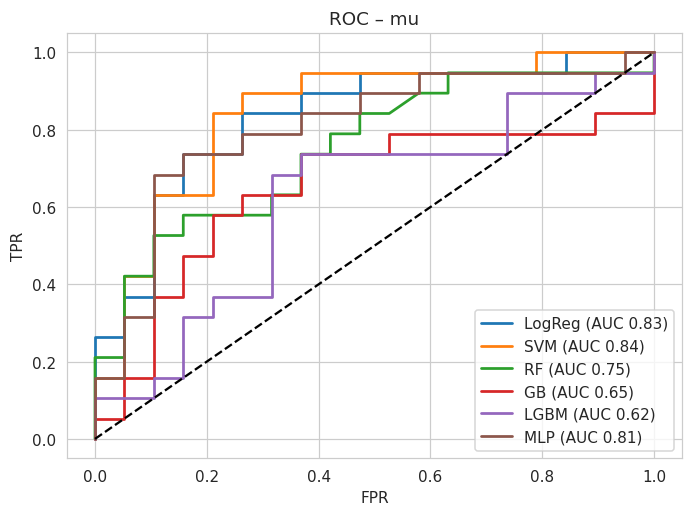

✅ mu: mejor SVM  AUC=0.845  → /content/drive/MyDrive/GrandMeanNorm/best_mu_fold1.pkl


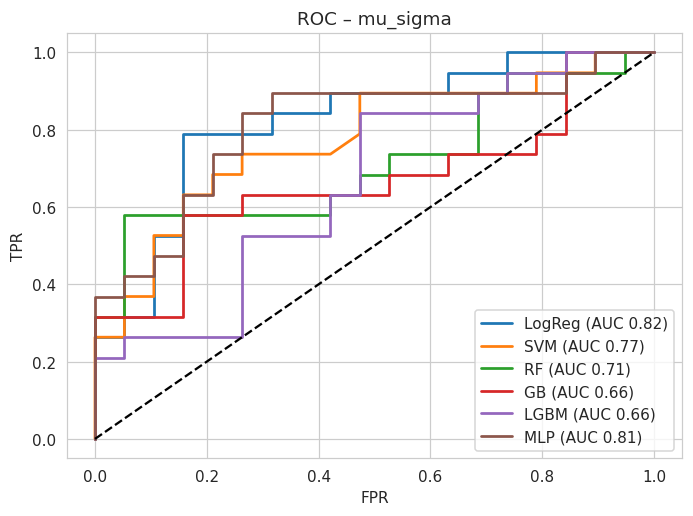

✅ mu_sigma: mejor LogReg  AUC=0.823  → /content/drive/MyDrive/GrandMeanNorm/best_mu_sigma_fold1.pkl

Resumen comparativo (↑ mejor):
 Model  Variant  Accuracy Precision    Recall        F1       AUC       Thr Dim
LogReg       mu  0.789474  0.823529  0.736842  0.777778  0.833795  0.628641  24
   SVM       mu  0.815789       0.8  0.842105  0.820513  0.844875  0.507423  24
    RF       mu  0.710526  0.785714  0.578947  0.666667  0.752078     0.615  24
    GB       mu  0.684211  0.733333  0.578947  0.647059  0.648199  0.740412  24
  LGBM       mu  0.684211  0.684211  0.684211  0.684211  0.623269  0.653279  24
   MLP       mu  0.789474  0.866667  0.684211  0.764706  0.806094  0.929644  24
LogReg mu_sigma  0.815789  0.833333  0.789474  0.810811  0.822715   0.52112  28
   SVM mu_sigma  0.736842  0.764706  0.684211  0.722222  0.774238  0.532566  28
    RF mu_sigma  0.763158  0.916667  0.578947  0.709677  0.714681  0.572973  28
    GB mu_sigma  0.710526  0.785714  0.578947  0.666667   0.66482  0

In [20]:
# %% ─────────── Clasificación AD vs CN  (μ  vs  μ+σ) ───────────
"""
Requiere en memoria: vae, DEVICE, clf_train_data, test_ad_cn_data,
clf_train_labels, test_ad_cn_labels_bin, PROJECT_DIR, FOLD_NUMBER, SEED
"""

import os, pickle, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns, lightgbm as lgb, torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing   import RobustScaler
from sklearn.decomposition   import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics         import (accuracy_score, precision_score, recall_score,
                                     f1_score, roc_auc_score, roc_curve)
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.base            import clone

# ─────────────────── ajustes visuales / warnings ───────────────────
warnings.filterwarnings("ignore", category=UserWarning)
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 110
#lgb.basic._config.set({"verbosity": -1})      # silencia LightGBM

# ───────────────────────── helpers ─────────────────────────
def encode_latents(encoder, tensors, use_sigma=False, batch=128):
    """Devuelve array (N, latent_dim [×2]) con μ o μ+σ."""
    dl, outs = DataLoader(TensorDataset(tensors),
                          batch_size=batch, pin_memory=True), []
    encoder.eval()
    with torch.no_grad():
        for (x,) in dl:
            mu, logvar = encoder(x.to(DEVICE))
            z = torch.cat([mu, torch.exp(0.5*logvar)], 1) if use_sigma else mu
            outs.append(z.cpu().numpy())
    return np.vstack(outs)

def youden_threshold(y_true, y_prob):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    return thr[np.argmax(tpr - fpr)]

def run_variant(tag:str, use_sigma:bool=False):
    # 1) Latentes
    Z_tr = encode_latents(vae.encoder, clf_train_data, use_sigma)
    Z_te = encode_latents(vae.encoder, test_ad_cn_data, use_sigma)

    # 2) RobustScaler + PCA (95 % var)
    scaler = RobustScaler()
    Z_tr   = scaler.fit_transform(Z_tr);  Z_te = scaler.transform(Z_te)
    pca    = PCA(0.95, random_state=SEED)
    Z_tr   = pca.fit_transform(Z_tr);     Z_te = pca.transform(Z_te)
    n_dim  = Z_tr.shape[1]

    # 3) Modelos y grids
    base = {
        "LogReg": LogisticRegression(max_iter=2000, class_weight="balanced"),
        "SVM":    SVC(kernel="linear", probability=True, class_weight="balanced"),
        "RF":     RandomForestClassifier(n_estimators=400, class_weight="balanced",
                                         random_state=SEED),
        "GB":     GradientBoostingClassifier(n_estimators=300, random_state=SEED),
        "LGBM":   lgb.LGBMClassifier(objective="binary", n_estimators=600,
                                     learning_rate=0.05, subsample=.8,
                                     colsample_bytree=.8, class_weight="balanced",
                                     random_state=SEED, verbosity=-1),
        "MLP":    MLPClassifier(max_iter=800, random_state=SEED)
    }
    grids = {
        "LogReg": {'C':[.01,.1,1,10]},
        "SVM":    {'C':[.01,.1,1,10]},
        "RF":     {'max_depth':[None,5,10]},
        "GB":     {'learning_rate':[.01,.05,.1],'max_depth':[3,5]},
        "LGBM":   {'num_leaves':[31,63], 'reg_lambda':[0.,1.]},
        "MLP":    {'hidden_layer_sizes':[(100,),(150,),(100,50)],
                   'alpha':[1e-5,1e-4,1e-3]}
    }

    inner   = StratifiedKFold(3, shuffle=True, random_state=SEED)
    y_tr    = clf_train_labels.numpy()
    y_te    = test_ad_cn_labels_bin
    metrics, best_params, best_models, roc_probs = {}, {}, {}, {}

    for name, model in base.items():
        gs = GridSearchCV(model, grids[name], cv=inner,
                          scoring="roc_auc", n_jobs=-1)
        gs.fit(Z_tr, y_tr)
        best_params[name] = gs.best_params_
        best_models[name] = gs.best_estimator_        # ya entrenado en cv

        y_prob = best_models[name].predict_proba(Z_te)[:,1]
        thr    = youden_threshold(y_te, y_prob)
        y_pred = (y_prob >= thr).astype(int)

        metrics[name] = dict(Variant=tag, Accuracy=accuracy_score(y_te, y_pred),
                             Precision=precision_score(y_te, y_pred, zero_division=0),
                             Recall=recall_score(y_te, y_pred, zero_division=0),
                             F1=f1_score(y_te, y_pred, zero_division=0),
                             AUC=roc_auc_score(y_te, y_prob), Thr=thr, Dim=n_dim)
        roc_probs[name] = y_prob

    # 4) Curva ROC combinada
    plt.figure()
    for n, prob in roc_probs.items():
        fpr,tpr,_ = roc_curve(y_te, prob)
        plt.plot(fpr,tpr,lw=1.8,label=f"{n} (AUC {metrics[n]['AUC']:.2f})")
    plt.plot([0,1],[0,1],'k--'); plt.title(f"ROC – {tag}")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()

    # 5) guardar mejor modelo (según AUC) re-entrenado con todo el train
    best_name = max(metrics, key=lambda k: metrics[k]["AUC"])
    final_est = clone(base[best_name]).set_params(**best_params[best_name])
    final_est.fit(Z_tr, y_tr)
    fname = os.path.join(PROJECT_DIR, f"best_{tag}_fold{FOLD_NUMBER}.pkl")
    with open(fname, "wb") as f: pickle.dump(final_est, f)

    print(f"✅ {tag}: mejor {best_name}  AUC={metrics[best_name]['AUC']:.3f}  → {fname}")
    return metrics



# ───────────────────── correr ambas variantes ─────────────────────
metrics_mu       = run_variant("mu",       use_sigma=False)
metrics_mu_sigma = run_variant("mu_sigma", use_sigma=True)

# ───────────────────── resumen en tabla ─────────────────────
def to_df(mdict): return pd.DataFrame(mdict).T.reset_index().rename(columns={'index':'Model'})
summary = pd.concat([
    to_df(metrics_mu),
    to_df(metrics_mu_sigma)
], ignore_index=True)

print("\nResumen comparativo (↑ mejor):")
print(summary.round(3).to_string(index=False))  # <- muestra todo en consola




